In [1]:
# basic imports for modelling notebook
import numpy as np
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit

import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
df=pd.read_csv('../data/modelling_3_data.csv')

In [3]:
df.columns

Index(['year', 'month', 'carrier', 'airport', 'arr_flights', 'arr_del15',
       'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct',
       'arr_cancelled', 'arr_diverted', 'arr_delay', 'carrier_delay',
       'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay',
       'date', 'month_sin', 'month_cos', 'arr_flights_ewma', 'arr_del15_ewma',
       'arr_cancelled_ewma', 'arr_diverted_ewma', 'arr_delay_ewma',
       'carrier_ct_ewma', 'weather_ct_ewma', 'nas_ct_ewma', 'security_ct_ewma',
       'late_aircraft_ct_ewma', 'carrier_delay_ewma', 'weather_delay_ewma',
       'nas_delay_ewma', 'security_delay_ewma', 'late_aircraft_delay_ewma',
       'past_years_monthly_ewma'],
      dtype='object')

In [4]:
df

,year,month,carrier,airport,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,...,weather_ct_ewma,nas_ct_ewma,security_ct_ewma,late_aircraft_ct_ewma,carrier_delay_ewma,weather_delay_ewma,nas_delay_ewma,security_delay_ewma,late_aircraft_delay_ewma,past_years_monthly_ewma
0,2019,1,9E,ABE,40.0,8.0,3.48,0.0,2.18,0.0,...,0.287031,1.766113,0.000000e+00,2.881582,340.750000,26.937500,46.224609,0.000000,204.533203,NaN
1,2020,1,9E,ABE,50.0,6.0,4.88,0.0,0.94,0.0,...,0.153117,0.213864,0.000000e+00,2.130120,147.069519,8.108139,6.091852,0.000000,137.650277,387.00
2,2021,1,9E,ABE,110.0,1.0,0.63,0.0,0.38,0.0,...,0.057317,0.157476,0.000000e+00,0.748243,61.062772,2.766047,4.832390,0.000000,27.533790,389.00
3,2022,1,9E,ABE,119.0,14.0,5.43,1.0,6.83,0.0,...,0.041660,3.525937,0.000000e+00,2.299265,258.827408,2.174503,96.235067,0.000000,106.932992,210.50
4,2023,1,9E,ABE,14.0,1.0,0.00,1.0,0.00,0.0,...,0.291647,1.509828,1.296875e-02,0.752849,229.284482,9.285838,77.758731,0.390625,33.093488,381.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178742,2022,11,YV,YUM,2.0,0.0,0.00,0.0,0.00,0.0,...,0.002065,0.294839,1.831055e-06,2.029243,147.900232,0.280000,28.881659,0.000183,189.779999,551.00
178743,2019,12,YV,YUM,59.0,19.0,3.72,0.0,3.77,0.0,...,0.013125,1.908281,0.000000e+00,3.155937,227.125000,1.875000,55.500000,0.000000,259.921875,NaN
178744,2020,12,YV,YUM,30.0,4.0,3.09,0.0,0.00,0.0,...,0.004036,0.116321,0.000000e+00,0.799789,50.023926,0.522949,3.126953,0.000000,31.874695,1178.00
178745,2021,12,YV,YUM,38.0,8.0,3.66,1.0,0.86,0.0,...,0.057035,1.357770,9.375000e-04,4.632178,138.918969,3.359886,46.409304,0.093750,335.359253,996.50


In [5]:
# Step 1: Split train and test
train_val_df = df[df['year'] < 2023].copy()
test_df = df[df['year'] == 2023].copy()

# Step 2: Drop unwanted columns
drop_cols = ['month', 'carrier', 'airport', 'arr_flights', 'arr_del15',
       'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct',
       'arr_cancelled', 'arr_diverted', 'carrier_delay',
       'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay',
       'date']
target = 'arr_delay'

# Optional: keep row index for final mapping
train_val_df = train_val_df.reset_index(drop=True)


In [6]:
print(df['arr_delay'].describe())

count    178747.000000
mean       3868.713998
std       11909.596123
min           0.000000
25%         290.000000
50%         903.000000
75%        2552.000000
max      438783.000000
Name: arr_delay, dtype: float64



🌀 Fold 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4111
[LightGBM] [Info] Number of data points in the train set: 26033, number of used features: 19
[LightGBM] [Info] Start training from score 3169.459186
✅ LightGBM MAE: 1756.38
✅ XGBoost MAE: 1748.54

🌀 Fold 2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4111
[LightGBM] [Info] Number of data points in the train set: 52062, number of used features: 19
[LightGBM] [Info] Start training from score 4189.506665
✅ LightGBM MAE: 1096.91
✅ XGBoost MAE: 1103.81

🌀 Fold 3
[LightGBM] [Info] Auto-choosing row-wise multi-threading, 

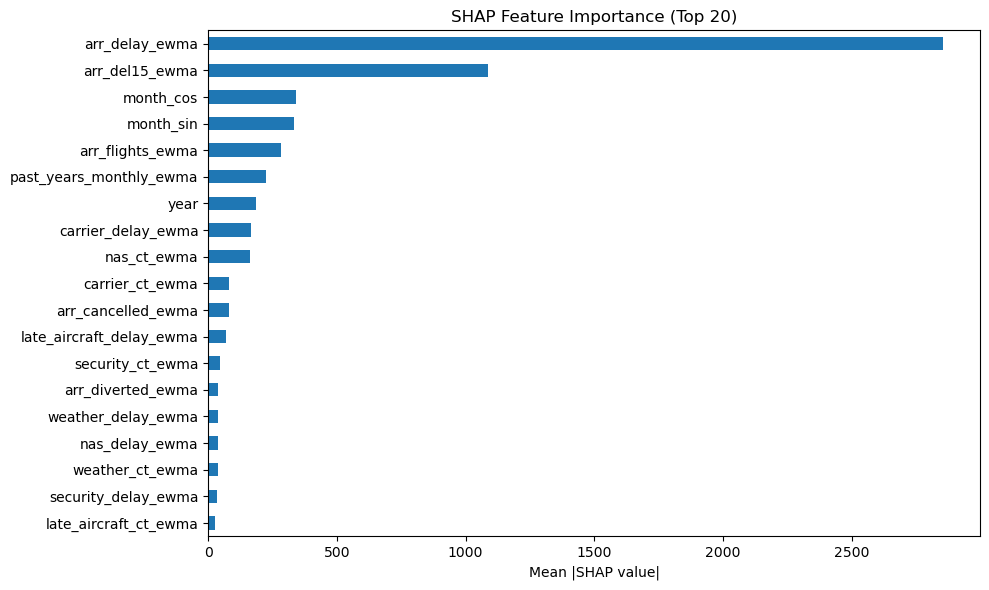


📌 SHAP Waterfall Plot for One Prediction:


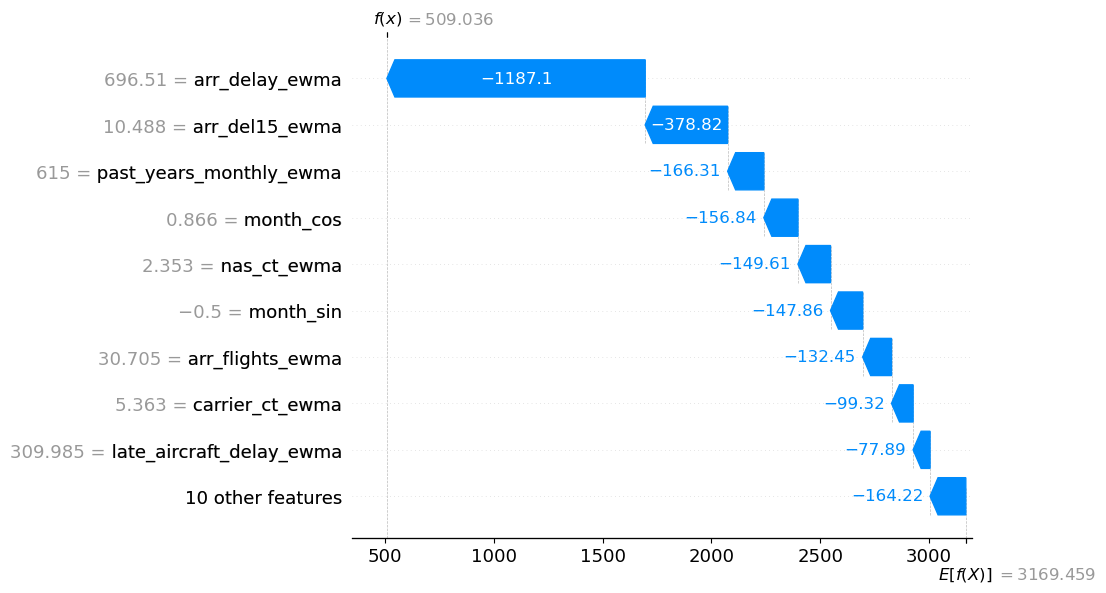


📊 SHAP Summary Plot (Top Features Distribution):


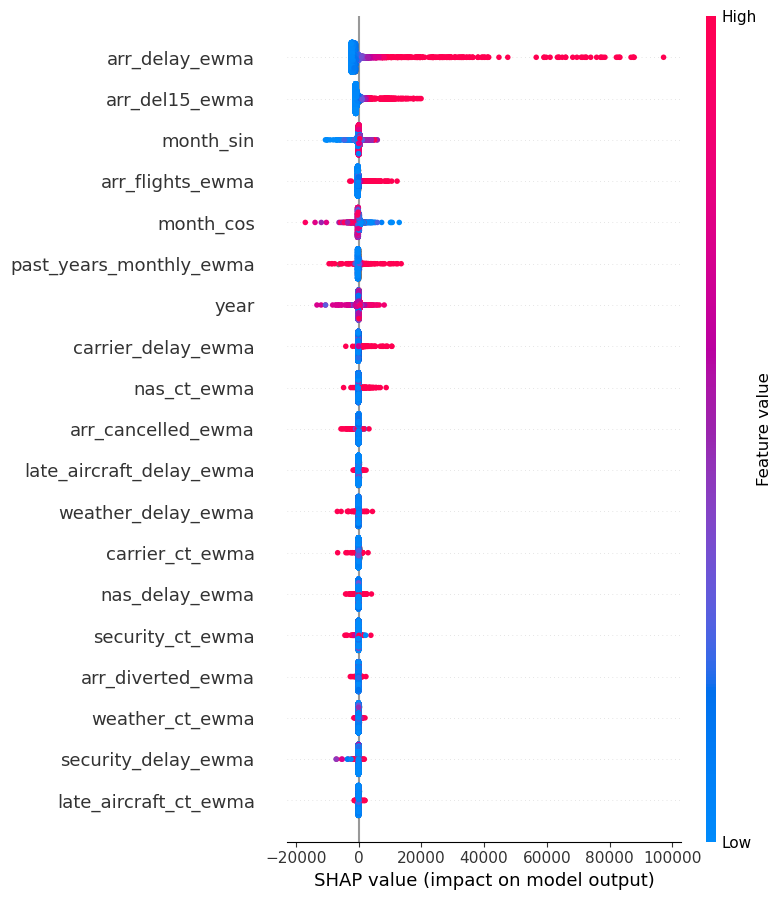

In [7]:
# Step 3: Define features
X = train_val_df.drop(columns=drop_cols + [target])
y = train_val_df[target]

# Step 4: Time-based cross-validation
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Results storage
model_results = {
    'lgbm': {'maes': []},
    'xgb': {'maes': []}
}
shap_feature_importance_list = []
example_shap_values = None  # For waterfall plot

for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
    print(f"\n🌀 Fold {fold+1}")
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # ========== LightGBM ==========
    lgb_model = LGBMRegressor(random_state=42)
    lgb_model.fit(X_train, y_train)
    lgb_preds = lgb_model.predict(X_val)
    lgb_mae = mean_absolute_error(y_val, lgb_preds)
    model_results['lgbm']['maes'].append(lgb_mae)

    # ========== XGBoost ==========
    xgb_model = xgb.XGBRegressor(random_state=42)
    xgb_model.fit(X_train, y_train)
    xgb_preds = xgb_model.predict(X_val)
    xgb_mae = mean_absolute_error(y_val, xgb_preds)
    model_results['xgb']['maes'].append(xgb_mae)

    # ========== SHAP for LGBM ==========
    # Sample for speed
    X_sample = X_train.sample(n=min(5000, len(X_train)), random_state=42)
    explainer = shap.TreeExplainer(lgb_model)
    shap_values = explainer.shap_values(X_sample)

    # Mean absolute SHAP per feature
    mean_shap_importance = np.abs(shap_values).mean(axis=0)
    shap_feature_importance_list.append(pd.Series(mean_shap_importance, index=X.columns))
    
    # Save one example for waterfall plot
    if example_shap_values is None:
        example_shap_values = shap.Explanation(values=shap_values[0], base_values=explainer.expected_value,
                                               data=X_sample.iloc[0], feature_names=X_sample.columns)

    # ========== Fold Results ==========
    print(f"✅ LightGBM MAE: {lgb_mae:.2f}")
    print(f"✅ XGBoost MAE: {xgb_mae:.2f}")

# ========== Final Results ==========
print("\n📊 Final Cross-Validation Results:")
print(f"LightGBM Mean MAE: {np.mean(model_results['lgbm']['maes']):.2f}")
print(f"XGBoost Mean MAE: {np.mean(model_results['xgb']['maes']):.2f}")

# ========== SHAP Bar Plot ==========
mean_shap_df = pd.concat(shap_feature_importance_list, axis=1).mean(axis=1).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
mean_shap_df.head(20).plot(kind='barh')
plt.title("SHAP Feature Importance (Top 20)")
plt.xlabel("Mean |SHAP value|")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# ========== SHAP Waterfall Plot ==========
print("\n📌 SHAP Waterfall Plot for One Prediction:")
shap.plots.waterfall(example_shap_values)
print("\n📊 SHAP Summary Plot (Top Features Distribution):")
shap.summary_plot(shap_values, X_sample, plot_type="dot")


🔍 SHAP Dependence Plot (with auto-detected interaction):


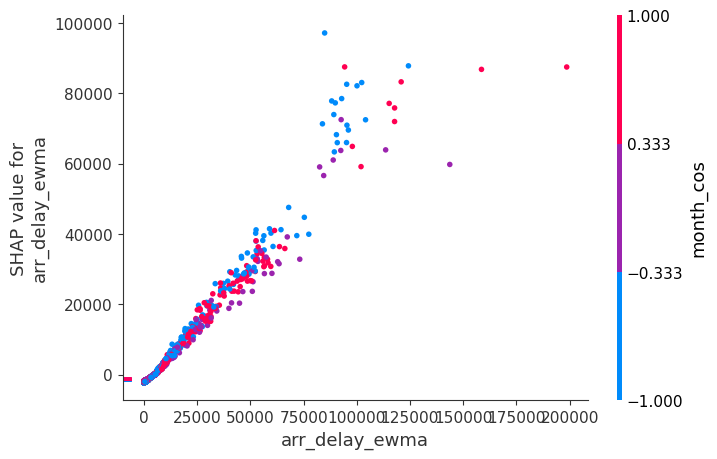

In [8]:
# ========== SHAP Dependence Plot with Interaction ==========
print("\n🔍 SHAP Dependence Plot (with auto-detected interaction):")
shap.dependence_plot("arr_delay_ewma", shap_values, X_sample)